In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [3]:
import pandas as pd
import numpy as np
from scipy import stats
from datetime import datetime
''' Sn properties - Masses, Ratios, Cup Configurations, ... '''
from sn_config import *
'''Classes for Reading in the Data and applying Internal Normalisation'''
from nu_data_reduction import NU_data_read, int_norm, evaluation
import pylab as plt
from scipy import stats
import os.path
import re
#%pylab inline

In [19]:
path = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2015-03-25/"
path_sav = "/Volumes/friebelm/PhD/NU Plasma/Measurements/compilation/"
path_all = "/Volumes/friebelm/PhD/NU Plasma/Measurements/2017-05-31/"
files_start = 4547
files_end = 4713


In [5]:
# cup configuration
#cup_config = cycle_Sb
cup_config = cycles2
# Isotopes used for Interference correction
corr_isotopes_1 = {"Cd" : "111", "Te" : "126"}
corr_isotopes_2 = {"Cd" : "111","Te" : "125", "Xe" : "129"}
corr_isotopes_Sb = {"Te": "125"}
# Mass Range of cup configuration
mass_range = cycles2_mass_range
#isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124"], ["117", "118", "119", "122", "124"]]
isotopes = [["111", "112", "114", "115", "116", "117", "118", "119", "122", "124", "125", "126", "129"]]
#isotopes = [["116", "117", "118", "119", "122", "124"]]
denom_isotope = "120"
isotope_column = ["111", "112", "114", "115", "116", "117", "118", "119", "122", "124", "125", "126", "129"]
data_sample_column = [(i + "/" + "120") for i in isotope_column]
print data_sample_column
#number of iterations for beta
iter_beta = 10

# Interference_corr on the denominator isotope
isotope_denom_corr = True

blk_corr = True

['111/120', '112/120', '114/120', '115/120', '116/120', '117/120', '118/120', '119/120', '122/120', '124/120', '125/120', '126/120', '129/120']


In [6]:
def mad_based_outlier(points, thresh=3.5):
        """
        Returns a boolean array with True if points are outliers and False
        otherwise.

        Parameters:
        -----------
            points : An numobservations by numdimensions array of observations
            thresh : The modified z-score to use as a threshold. Observations with
                a modified z-score (based on the median absolute deviation) greater
                than this value will be classified as outliers.

        Returns:
        --------
            mask : A numobservations-length boolean array.

        References:
        ----------
            Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
            Handle Outliers", The ASQC Basic References in Quality Control:
            Statistical Techniques, Edward F. Mykytka, Ph.D., Editor.
        """
        if len(points.shape) == 1:
            points = points[:,None]
        median = np.median(points, axis=0)
        diff = np.sum((points - median)**2, axis=-1)
        diff = np.sqrt(diff)
        med_abs_deviation = np.median(diff)

        modified_z_score = 0.6745 * diff / med_abs_deviation

        return modified_z_score > thresh

#outlier rejection
def mad_outlier_rejection(df):
    data_sample_outlier = pd.DataFrame()
    columns = df.columns.tolist()
    for column in columns:
        data_sample_outlier[column] = df[column].where(~mad_based_outlier(df[column]), other=np.NaN)
    return data_sample_outlier

def mad_outlier(df):
    data_sample_outlier = pd.DataFrame()
    columns = df.columns.tolist()
    for column in columns:
        data_sample_outlier[column] = df[column].where(mad_based_outlier(df[column]), other=np.NaN)
    return data_sample_outlier

In [20]:
filenames = os.listdir(path_all)

In [21]:
sample_ls = []
for i in filenames:
    sample = re.search(r""+"Data_"+"(.*).csv", i)
    if sample == None:
        None
    else:
        sample = sample.group(1)
        df = NU_data_read(path_all, sample, cup_config)
        sample_name = df.extract_metadata(sample, "Sample Name")
        sample_ls.append(sample)

In [22]:
columns = ["cycle", "sample", "date","H10 (Z1)", "H9 (Z1)", "H8 (Z1)", "H7 (Z1)", "H6 (Z1)", "H5 (Z1)", "H4 (Z1)", "H3 (Z1)", "H2 (Z1)", "H1 (Z1)", "Ax (Z1)", "L1 (Z1)", "L2 (Z1)", "L3 (Z1)", "L4 (Z1)"]
df_all = pd.DataFrame(columns = columns)
for sample in sample_ls:
    df = NU_data_read(path_all, sample, cup_config)
    datafile = "Data_" + str(sample) + ".csv"
    data = pd.read_csv(path_all + datafile, skiprows=58, index_col='Cycle')
    
    data_zero = data.ix[:,"H10 (Z1)":"L4 (Z1)"]
    data_zero["cycle"] = data_zero.index.values
        #data_1_corr = mad_outlier_rejection(data_1_corr)
        
    sample_name = df.extract_metadata(sample, "Sample Name")
    date = df.extract_metadata(sample, "Date")
    starttime = df.extract_metadata(sample, "Start Time")
    data_zero["date"] = datetime.strptime(date+starttime, '%d/%m/%Y%H:%M')
    data_zero["sample"] = sample_name
    df_all = pd.concat([df_all,data_zero], axis=0, ignore_index=True)
    #df_all = df_all.append(data_1_corr)
    df_all = df_all[columns]
df_all.set_index("date", inplace = True)
df_all

/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/marf/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/ind

,cycle,sample,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1)
date,,,,,,,,,,,,,,,,,
2017-06-02 11:59:00,1.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,2.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,3.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,4.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,5.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,6.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,7.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,8.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830
2017-06-02 11:59:00,9.0,blank sol,0.0,0.0,-0.005967,-0.001573,-0.005387,-0.006147,-0.003123,-0.002639,-0.004878,-0.004818,-0.005879,-0.005179,-0.004282,-0.003775,-0.001830


In [28]:
def mean(x):
    mean = np.nanmean(x) 
    return mean

df_all_mean = df_all.drop("cycle", axis=1).groupby(df_all.index).agg(mean)
df_all_mean["sample"] = df_all[~df_all.index.duplicated(keep='first')]["sample"]
#df_all_mean.to_csv(path_all+"zeros.csv")
df_all_mean
#(df_all_mean["H6 (1)"].mean() - (df_all_mean["H4 (1)"].mean()/24.22*32.6))*1000

,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1),sample
date,,,,,,,,,,,,,,,,
2017-05-31 17:49:00,0.0,0.0,-0.005944,-0.001529,-0.005371,-0.006108,-0.003105,-0.002625,-0.000594,-0.004844,-0.005912,-0.005202,-0.004355,-0.003802,-0.001832,blank sol
2017-05-31 18:00:00,0.0,0.0,-0.005942,-0.001532,-0.005369,-0.006117,-0.003095,-0.002623,-0.004869,-0.004848,-0.005922,-0.005217,-0.004348,-0.003819,-0.001827,blank sol
2017-05-31 18:17:00,0.0,0.0,-0.005943,-0.001526,-0.005362,-0.006114,-0.003097,-0.002611,-0.001783,-0.004842,-0.005914,-0.005196,-0.004330,-0.003788,-0.001812,bomb blk J.W. Leach 3a Aliq.2
2017-05-31 18:38:00,0.0,0.0,-0.005949,-0.001524,-0.005372,-0.006123,-0.003102,-0.002629,-0.004794,-0.004865,-0.005921,-0.005209,-0.004347,-0.003815,-0.001845,ZH09-05 23.3_3b_3 Aliq.4
2017-05-31 18:52:00,0.0,0.0,-0.005951,-0.001532,-0.005369,-0.006118,-0.003105,-0.002639,-0.004657,-0.004858,-0.005910,-0.005202,-0.004355,-0.003817,-0.001834,J.W. Leach 3a Aliq. 2 bomb
2017-05-31 19:01:00,0.0,0.0,-0.005958,-0.001549,-0.005379,-0.006139,-0.003109,-0.002642,-0.004855,-0.004862,-0.005938,-0.005225,-0.004360,-0.003827,-0.001850,blank sol
2017-05-31 20:01:00,0.0,0.0,-0.005990,-0.001592,-0.005406,-0.006167,-0.003120,-0.002637,0.000964,-0.004861,-0.005976,-0.005222,-0.004384,-0.003820,-0.001884,NIST 200ppb
2017-05-31 20:05:00,0.0,0.0,-0.005986,-0.001593,-0.005403,-0.006178,-0.003126,-0.002633,-0.001482,-0.004875,-0.005971,-0.005203,-0.004361,-0.003821,-0.001871,NIST 200ppb
2017-05-31 20:15:00,0.0,0.0,-0.005983,-0.001590,-0.005429,-0.006174,-0.003144,-0.002666,-0.004917,-0.004898,-0.005987,-0.005258,-0.004390,-0.003858,-0.001895,blank sol


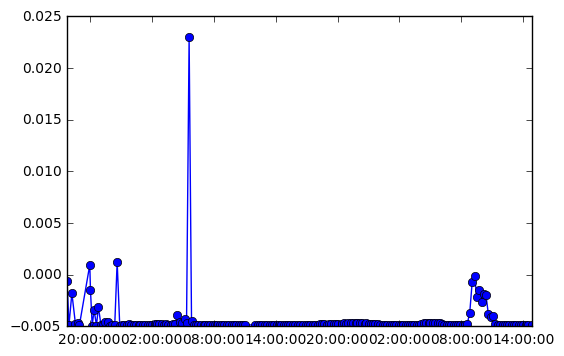

In [24]:
sel_cup = "H2 (Z1)"
plt.plot(df_all_mean.index, df_all_mean[sel_cup], linestyle='-', marker='o', color='b')
plt.show()

In [25]:
outliers = mad_outlier(df_all_mean.drop("sample", axis=1))
outliers = outliers.dropna(how='all')
dates_outlier = outliers.index.tolist()
samples = df_all_mean.ix[dates_outlier]["sample"]
outliers["sample"] = samples
outliers
#outliers.to_csv(path_all+"outliers_zeros.csv")

In [27]:
outlier_corr = mad_outlier_rejection(df_all_mean.drop("sample", axis=1))
outlier_corr
#outlier_corr.to_csv(path_all+"zeros_outlier_corr.csv")

,H10 (Z1),H9 (Z1),H8 (Z1),H7 (Z1),H6 (Z1),H5 (Z1),H4 (Z1),H3 (Z1),H2 (Z1),H1 (Z1),Ax (Z1),L1 (Z1),L2 (Z1),L3 (Z1),L4 (Z1)
date,,,,,,,,,,,,,,,
2017-05-31 17:49:00,0.0,0.0,-0.005944,NaN,-0.005371,-0.006108,-0.003105,-0.002625,NaN,-0.004844,-0.005912,-0.005202,NaN,-0.003802,-0.001832
2017-05-31 18:00:00,0.0,0.0,-0.005942,NaN,-0.005369,-0.006117,-0.003095,-0.002623,-0.004869,-0.004848,-0.005922,-0.005217,-0.004348,NaN,-0.001827
2017-05-31 18:17:00,0.0,0.0,-0.005943,NaN,-0.005362,-0.006114,-0.003097,-0.002611,NaN,-0.004842,-0.005914,-0.005196,-0.004330,-0.003788,-0.001812
2017-05-31 18:38:00,0.0,0.0,-0.005949,NaN,-0.005372,-0.006123,-0.003102,-0.002629,-0.004794,-0.004865,-0.005921,-0.005209,-0.004347,-0.003815,-0.001845
2017-05-31 18:52:00,0.0,0.0,-0.005951,NaN,-0.005369,-0.006118,-0.003105,-0.002639,NaN,-0.004858,-0.005910,-0.005202,NaN,-0.003817,-0.001834
2017-05-31 19:01:00,0.0,0.0,-0.005958,-0.001549,-0.005379,-0.006139,-0.003109,-0.002642,-0.004855,-0.004862,-0.005938,-0.005225,NaN,NaN,-0.001850
2017-05-31 20:01:00,0.0,0.0,-0.005990,-0.001592,-0.005406,-0.006167,-0.003120,-0.002637,NaN,-0.004861,NaN,-0.005222,NaN,NaN,-0.001884
2017-05-31 20:05:00,0.0,0.0,-0.005986,-0.001593,-0.005403,-0.006178,-0.003126,-0.002633,NaN,-0.004875,NaN,-0.005203,NaN,NaN,-0.001871
2017-05-31 20:15:00,0.0,0.0,-0.005983,-0.001590,-0.005429,-0.006174,-0.003144,-0.002666,-0.004917,NaN,NaN,-0.005258,NaN,NaN,NaN


In [ ]:
df_all.to_csv(path_all + "blanks.csv", mode='w', header=True)

In [18]:
df_all_mean.to_csv(path_all + "blanks_mean.csv", mode='w', header=True)

In [229]:
df_internal_norm_mean_sd.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_mean_no_bgd_corr.csv")

In [389]:
epsilon.to_csv(path + "Sn_H8_L4_2_cycles_internal_norm_epsilon_bgd_corr.csv")